# Train Encoder for CMP_code classification

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/BSC/tfm/encoder/lib/utils.py .

Mounted at /content/drive


In [2]:
%%capture
!pip install transformers

In [3]:
from utils import *

from random import *
import os
import argparse
import sys
import pandas as pd
import torch
import numpy as np

from transformers import BertTokenizer
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

## Functions

In [6]:
def train(model: BertClassifier, tokenizer:BertTokenizer, labels_dict:dict, train_data:pd.DataFrame, val_data:pd.DataFrame, epochs:int, criterion, optimizer, bs:int=2):
    """
    Function to train the 'model' for a number of epochs and evaluate it with 'val_data'
    @param model: the model to train, the classifier.
    @param tokenizer: the Tokenizer used to tokenize the sentences
    @param labels_dict: a dictionary relting the original labels with the codification
    @param train_data: the dataframe containing the training data
    @param val_data: the dataframe contining the validation data
    @param epochs: the number of epochs to train the model for
    @param criterion: the loss used to train the model
    @param optimizer: the optimizer used to train the model
    @param bs: the batch size used to train the model
    return: the train and validaton accuracy and losses per epoch
    """
    # Generate the DataLoaders for Training and Validation
    train_dataloader = torch.utils.data.DataLoader(Dataset(train_data, tokenizer, labels_dict), batch_size=bs, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(Dataset(val_data, tokenizer, labels_dict), batch_size=bs)

    # Move to corresponding device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    # Placeholders for storing metric evolution
    train_acc, train_loss = np.zeros(epochs), np.zeros(epochs)
    val_acc, val_loss = np.zeros(epochs), np.zeros(epochs)

    # For every epoch
    for epoch_num in range(epochs):
        print(f"Epoch {epoch_num+1}/{epochs}")

        total_acc_train, total_loss_train = 0, 0
        total_acc_val, total_loss_val = 0, 0

        ##### TRAIN #####
        # For every batch in the Dataloader
        for train_input, train_label in tqdm(train_dataloader):
            # Obtain inputs and move them to corresponding device
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            # Forward pass
            output = model(input_id, mask)

            # Accuracy and Loss computation       
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        with torch.no_grad():
            ##### VALIDATE #####
            # For every batch in the Dataloader
            for val_input, val_label in val_dataloader:
                # Obtain inputs and move them to corresponding device
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                # Forward pass
                output = model(input_id, mask)
                
                # Accuracy and Loss computation
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
        
        train_acc[epoch_num] = total_acc_train / len(train_data)
        train_loss[epoch_num] = total_loss_train / len(train_data)
        val_acc[epoch_num] = total_acc_val / len(val_data)
        val_loss[epoch_num] = total_loss_val / len(val_data)

        print(f'Epochs: {epoch_num + 1} '+
            f'| Train Loss: {train_loss[epoch_num]: .3f} | Train Accuracy: {train_acc[epoch_num]: .3f} '+
            f'| Val Loss: {val_loss[epoch_num]: .3f} | Val Accuracy: {val_acc[epoch_num]: .3f}')
            
    return train_acc, train_loss, val_acc, val_loss


def evaluate(model: BertClassifier, tokenizer:BertTokenizer, labels_dict:dict, test_data:pd.DataFrame):
    """
    Function to evaluate the 'model' with 'test_data'
    @param model: the model to train, the classifier.
    @param tokenizer: the Tokenizer used to tokenize the sentences
    @param labels_dict: a dictionary relting the original labels with the codification
    @param test_data: the dataframe containing the data to test
    return: nothing
    """
    # Generate the DataLoader for the Testing DF
    test_dataloader = torch.utils.data.DataLoader(Dataset(test_data, tokenizer, labels_dict), batch_size=2)

    # Move to corresponding device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    total_acc_test = 0

    with torch.no_grad():
        # For every batch in the Dataloader
        for test_input, test_label in test_dataloader:
            # Obtain inputs and move them to corresponding device
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            # Forward pass
            output = model(input_id, mask)

            # ACcuracy computation
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [10]:
data_path = "/content/drive/MyDrive/BSC/tfm/encoder/dataset/CMPD_model_test_3_rile_simp.xlsx"
tokenizer_name = "dccuchile/bert-base-spanish-wwm-cased"
save_model_path = "/content/drive/MyDrive/BSC/tfm/encoder/results/torchmodel_weights.pth"
epochs = 2
lr = 1e-6
bs = 8
reduced = False
reduced_size = 5000
results_path = "/content/drive/MyDrive/BSC/tfm/encoder/results/"
print_graphs = True

# Obtain dataframe containing sentences and labels; and compute the number of classes
df = read_data(data_path, level_codes=1)
all_orig_labels = sorted(np.unique(list(df["cmp_code"])))
num_classes = len(all_orig_labels)
labels_dict = {f'{code}':i for i,code in enumerate(all_orig_labels)}

# Create tokenizer and model
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
model = BertClassifier(tokenizer_name = tokenizer_name, num_classes = num_classes)

# Define hyperparameters of the training
EPOCHS = epochs
LR = lr
BS = bs
BS_VAL = 8
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= LR)

# Split the dataset into training, validation and testing
np.random.seed(112)
perc_train, perc_val, perc_test = 0.8, 0.1, 0.1
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42),[int(perc_train*len(df)),int((perc_train+perc_val)*len(df))])
if reduced:
    n_samples = len(df) if reduced_size > len(df) else reduced_size
    train_data = train_df.iloc[0:int(n_samples*perc_train)]
    val_data = val_df.iloc[0:int(n_samples*perc_val)]
    test_data = test_df.iloc[0:int(n_samples*perc_test)]
else:
    train_data = train_df
    val_data = val_df
    test_data = test_df
print("Sizes of the target train, validation and test datasets:", len(train_data),len(val_data), len(test_data))

##### TRAIN #####
train_acc, train_loss, val_acc, val_loss = train(model, tokenizer, labels_dict, train_data, val_data, EPOCHS, loss_fn, optimizer, BS)

##### EVALUATE #####
evaluate(model,tokenizer, labels_dict, test_data)

Loading the data...


Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bi

Sizes of the target train, validation and test datasets: 16000 2000 2000
Epoch 1/10


100%|██████████| 2000/2000 [23:09<00:00,  1.44it/s]


Epochs: 1 | Train Loss:  0.457 | Train Accuracy:  0.147 | Val Loss:  0.401 | Val Accuracy:  0.319
Epoch 2/10


100%|██████████| 2000/2000 [23:11<00:00,  1.44it/s]


Epochs: 2 | Train Loss:  0.360 | Train Accuracy:  0.373 | Val Loss:  0.329 | Val Accuracy:  0.422
Epoch 3/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 3 | Train Loss:  0.309 | Train Accuracy:  0.449 | Val Loss:  0.300 | Val Accuracy:  0.451
Epoch 4/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 4 | Train Loss:  0.279 | Train Accuracy:  0.492 | Val Loss:  0.282 | Val Accuracy:  0.476
Epoch 5/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 5 | Train Loss:  0.257 | Train Accuracy:  0.530 | Val Loss:  0.271 | Val Accuracy:  0.499
Epoch 6/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 6 | Train Loss:  0.239 | Train Accuracy:  0.564 | Val Loss:  0.264 | Val Accuracy:  0.499
Epoch 7/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 7 | Train Loss:  0.223 | Train Accuracy:  0.596 | Val Loss:  0.259 | Val Accuracy:  0.509
Epoch 8/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 8 | Train Loss:  0.207 | Train Accuracy:  0.623 | Val Loss:  0.256 | Val Accuracy:  0.507
Epoch 9/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 9 | Train Loss:  0.193 | Train Accuracy:  0.653 | Val Loss:  0.256 | Val Accuracy:  0.504
Epoch 10/10


100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


Epochs: 10 | Train Loss:  0.179 | Train Accuracy:  0.682 | Val Loss:  0.258 | Val Accuracy:  0.497
Test Accuracy:  0.514


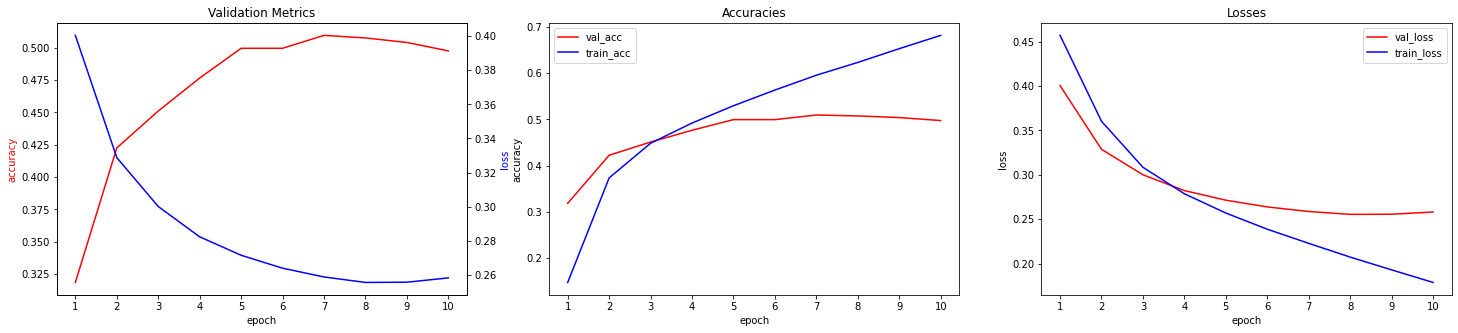

In [11]:
# Print training results and save model
if print_graphs:
    file_name=data_path.split("/")[-1].split(".")[0]
    title=f"{file_name} metrics"
    print_results(train_acc, train_loss, val_acc, val_loss, results_path, title)
save_path = os.path.join(save_model_path, "torchmodel_weights.pth")
torch.save(model.state_dict(), save_model_path)